In [4]:
from pedpy import load_trajectory
from pedpy import (
    Geometry,
    TrajectoryUnit,
    get_invalid_trajectory,
    is_trajectory_valid,
)
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely import LineString, Polygon

import warnings

warnings.filterwarnings("ignore")

%load_ext line_profiler
plt.rcParams["text.usetex"] = True

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [21]:
traj = load_trajectory(
    trajectory_file=pathlib.Path(
        "issues/000_mira/verify-profiles/1B110_haus_Aa_mirrored.txt"
    ),
    default_unit=TrajectoryUnit.METER,
    # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

In [22]:
traj.data = traj.data[(1500 < traj.data.frame) & (traj.data.frame < 1505)]

In [8]:
walkable_area = Polygon([(0.5, 3.5), (0.5, -3.5), (-19.5, -3.5), (-19.5, 3.5)])
obstacle = Polygon([(-7.8, -1.5), (-11.3, -1.5), (-11.3, 1.5), (-7.8, 1.5)])
geometry = Geometry(walkable_area=walkable_area, obstacles=[obstacle])

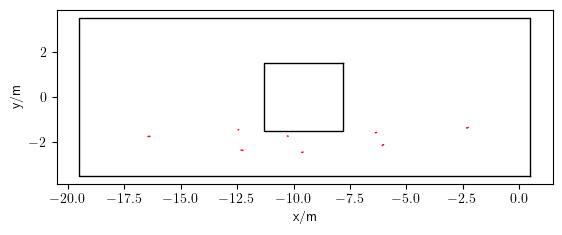

In [23]:
from pedpy import plot_measurement_setup

plot_measurement_setup(
    traj=traj,
    geometry=geometry,
).set_aspect("equal")

# Current

In [7]:
from pedpy import compute_individual_voronoi_polygons

In [24]:
from pedpy.methods.method_utils import _clip_voronoi_polygons
from scipy.spatial import Voronoi
from typing import Tuple, Optional


def compute_individual_voronoi_polygons_current(
    *,
    traj_data: pd.DataFrame,
    geometry: Geometry,
    cut_off: Optional[Tuple[float, int]] = None,
    use_blind_points: bool = True,
) -> pd.DataFrame:
    """Compute the individual voronoi cells for each person and frame.

    Args:
        traj_data (pd.DataFrame): trajectory data
        geometry (Geometry): bounding area, where pedestrian are supposed to be
        cut_off (Tuple[float, int]): radius of max extended voronoi cell (in
                m), number of linear segments in the approximation of circular
                arcs, needs to be divisible by 4!
        use_blind_points (bool): adds extra 4 points outside the geometry to
                also compute voronoi cells when less than 4 peds are in the
                geometry (default: on!)

    Returns:
        DataFrame containing the columns: 'ID', 'frame' and 'individual
        voronoi'.
    """
    dfs = []

    bounds = geometry.walkable_area.bounds
    x_diff = abs(bounds[2] - bounds[0])
    y_diff = abs(bounds[3] - bounds[1])
    clipping_diameter = 2 * max(x_diff, y_diff)

    blind_points = np.array(
        [
            [100 * (bounds[0] - x_diff), 100 * (bounds[1] - y_diff)],
            [100 * (bounds[2] + x_diff), 100 * (bounds[1] - y_diff)],
            [100 * (bounds[0] - x_diff), 100 * (bounds[3] + y_diff)],
            [100 * (bounds[2] + x_diff), 100 * (bounds[3] + y_diff)],
        ]
    )

    for frame, peds_in_frame in traj_data.groupby(traj_data.frame):
        points = peds_in_frame[["X", "Y"]].values
        points = np.concatenate([points, blind_points])

        # only skip analysis if less than 4 peds are in the frame and blind
        # points are turned off
        if not use_blind_points and len(points) - len(blind_points) < 4:
            log.warning(
                f"Not enough pedestrians (N="
                f"{len(points) -len(blind_points)}) available to "
                f"calculate Voronoi cells for frame = {frame}. "
                f"Consider enable use of blind points."
            )
            continue

        vor = Voronoi(points)
        voronoi_polygons = _clip_voronoi_polygons(vor, clipping_diameter)

        voronoi_polygons = voronoi_polygons[:-4]
        voronoi_in_frame = peds_in_frame.loc[:, ("ID", "frame", "points")]

        # Compute the intersecting area with the walkable area
        voronoi_in_frame["individual voronoi"] = shapely.intersection(
            voronoi_polygons, geometry.walkable_area
        )

        # Only consider the parts of a multipolygon which contain the position
        # of the pedestrian
        voronoi_in_frame.loc[
            shapely.get_type_id(voronoi_in_frame["individual voronoi"]) != 3,
            "individual voronoi",
        ] = voronoi_in_frame.loc[
            shapely.get_type_id(voronoi_in_frame["individual voronoi"]) != 3, :
        ].apply(
            lambda x: shapely.get_parts(x["individual voronoi"])[
                shapely.within(
                    x["points"], shapely.get_parts(x["individual voronoi"])
                )
            ][0],
            axis=1,
        )

        if cut_off is not None:
            num_edges = cut_off[1]
            radius = cut_off[0]
            quad_edges = int(num_edges / 4)
            voronoi_in_frame["individual voronoi"] = shapely.intersection(
                voronoi_in_frame["individual voronoi"],
                shapely.buffer(
                    peds_in_frame["points"], radius, quad_segs=quad_edges
                ),
            )

        dfs.append(voronoi_in_frame)

    return pd.concat(dfs)[["ID", "frame", "individual voronoi"]]

In [17]:
%lprun -f compute_individual_voronoi_polygons_current pedpy_voronoi_polygons = compute_individual_voronoi_polygons_current(traj_data=traj.data, geometry=geometry)

# polars

In [65]:
import geopolars as pl

In [66]:
def compute_individual_voronoi_polygons_polars(
    *,
    traj_data: pl.DataFrame,
    geometry: Geometry,
    cut_off: Optional[Tuple[float, int]] = None,
    use_blind_points: bool = True,
) -> pd.DataFrame:
    """Compute the individual voronoi cells for each person and frame.

    Args:
        traj_data (pd.DataFrame): trajectory data
        geometry (Geometry): bounding area, where pedestrian are supposed to be
        cut_off (Tuple[float, int]): radius of max extended voronoi cell (in
                m), number of linear segments in the approximation of circular
                arcs, needs to be divisible by 4!
        use_blind_points (bool): adds extra 4 points outside the geometry to
                also compute voronoi cells when less than 4 peds are in the
                geometry (default: on!)

    Returns:
        DataFrame containing the columns: 'ID', 'frame' and 'individual
        voronoi'.
    """
    dfs = []

    bounds = geometry.walkable_area.bounds
    x_diff = abs(bounds[2] - bounds[0])
    y_diff = abs(bounds[3] - bounds[1])
    clipping_diameter = 2 * max(x_diff, y_diff)

    blind_points = np.array(
        [
            [100 * (bounds[0] - x_diff), 100 * (bounds[1] - y_diff)],
            [100 * (bounds[2] + x_diff), 100 * (bounds[1] - y_diff)],
            [100 * (bounds[0] - x_diff), 100 * (bounds[3] + y_diff)],
            [100 * (bounds[2] + x_diff), 100 * (bounds[3] + y_diff)],
        ]
    )

    for frame, peds_in_frame in traj_data.groupby("frame"):
        points = peds_in_frame[["X", "Y"]].to_numpy()
        points = np.concatenate([points, blind_points])

        # only skip analysis if less than 4 peds are in the frame and blind
        # points are turned off
        if not use_blind_points and len(points) - len(blind_points) < 4:
            continue

        vor = Voronoi(points)
        voronoi_polygons = _clip_voronoi_polygons(vor, clipping_diameter)

        voronoi_polygons = voronoi_polygons[:-4]
        voronoi_in_frame = peds_in_frame.select(["ID", "frame"])

        # Compute the intersecting area with the walkable area
        # voronoi_in_frame["individual voronoi"] = shapely.intersection(
        #     voronoi_polygons, geometry.walkable_area
        # )

        voronoi_in_frame = voronoi_in_frame.with_columns(
            [
                pl.Series(
                    shapely.intersection(
                        voronoi_polygons, geometry.walkable_area
                    )
                )
            ]
        )

        # Only consider the parts of a multipolygon which contain the position
        # of the pedestrian
        # voronoi_in_frame.loc[
        #     shapely.get_type_id(voronoi_in_frame["individual voronoi"]) != 3,
        #     "individual voronoi",
        # ] = voronoi_in_frame.loc[
        #     shapely.get_type_id(voronoi_in_frame["individual voronoi"]) != 3, :
        # ].apply(
        #     lambda x: shapely.get_parts(x["individual voronoi"])[
        #         shapely.within(
        #             shapely.geometry.Point(x["X"], x["Y"]), shapely.get_parts(x["individual voronoi"])
        #         )
        #     ][0],
        #     axis=1,
        # )
        #
        #
        # if cut_off is not None:
        #     num_edges = cut_off[1]
        #     radius = cut_off[0]
        #     quad_edges = int(num_edges / 4)
        #     voronoi_in_frame["individual voronoi"] = shapely.intersection(
        #         voronoi_in_frame["individual voronoi"],
        #         shapely.buffer(
        #             peds_in_frame["points"], radius, quad_segs=quad_edges
        #         ),
        #     )

        dfs.append(voronoi_in_frame)

    return pl.concat(dfs)

AttributeError: module 'geopolars' has no attribute 'DataFrame'

In [64]:
polars_data = pl.from_pandas(traj.data[["ID", "frame", "X", "Y"]])
polars_voronoi_polygons = compute_individual_voronoi_polygons_polars(
    traj_data=polars_data, geometry=geometry
)

thread '<unnamed>' panicked at 'not implemented for dtype Object("object")', /home/runner/work/polars/polars/polars/polars-core/src/series/ops/null.rs:65:17
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: not implemented for dtype Object("object")

In [62]:
polars_voronoi_polygons

ID,frame
i64,i64
32,1503
416,1503
77,1503
395,1503
334,1503
251,1503
161,1503
337,1503
407,1503


In [ ]:
%lprun -f compute_individual_voronoi_polygons_current pedpy_voronoi_polygons = compute_individual_voronoi_polygons_current(traj_data=traj.data, geometry=geometry)